# Read PulseEKKO file

- irlib: https://github.com/njwilson23/irlib (MIT License)
- GPRPy: https://github.com/NSGeophysics/GPRPy (MIT License)

In [1]:
import os
import numpy as np
from struct import unpack
import matplotlib.pyplot as plt

## Using irlib to load data

The follow three functions `parse_header`, `parse_data`, and `read_pulseEKKO` were copied from the file
https://github.com/njwilson23/irlib/blob/master/irlib/pEKKOdriver.py ([#8a04be7](https://github.com/njwilson23/irlib/commit/8a04be7f9b86c2e0c9bedaa42eb5ccf6b40bbefc)).

In [2]:
def parse_header(lines):
    """ Read a header string and return a dictionary.
    str -> dict
    """
    meta = {}
    for line in lines:
        if "=" in line:
            k,v = line.split("=", 1)
            meta[k.strip()] = v.strip()
        elif (("-" in line) or ("/" in line)) and len(line.strip()) == 8:
            meta["date"] = line.strip()

    return meta


def parse_data(s):
    """ Read a data string and return a dictionary and a data array.
    str -> (dict, array)
    """
    i = 0
    dlist = []
    meta = {}

    while True:
        if len(s) < i+128:
            break
        hdr = unpack("32f", s[i:i+128])
        nsmp = int(hdr[2])
        d = unpack("{0}h".format(nsmp), s[i+128:i+128+2*nsmp])
        meta[i] = hdr
        dlist.append(d)
        i += (128 + 2*nsmp)

    # Pad short traces with zeros
    maxlen = max([len(a) for a in dlist])
    dlist_even = map(lambda a,n: a if len(a) == n else a+(n-len(a))*[0],
                     dlist, (maxlen for _ in dlist))
    darray = np.vstack(list(dlist_even)).T
    return meta, darray


def read_pulseEKKO(path):
    """ Search for header and data files matching path, open them, and return a
    dictionary of line metadata, a dictionary of trace metadata, and an array
    of radar data.
    str -> (dict, dict, array)
    """
    directory, nm = os.path.split(path)
    if nm + ".HD" not in os.listdir(directory):
        raise IOError("{0}.HD not found".format(nm))
    elif nm + ".DT1" not in os.listdir(directory):
        raise IOError("{0}.DT1 not found".format(nm))

    with open(path + ".HD", "r") as f:
        lnmeta = parse_header(f.readlines())

    with open(path + ".DT1", "rb") as f:
        trmeta, darray = parse_data(f.read())

    return lnmeta, trmeta, darray

In [3]:
line_meta, trace_meta, data = read_pulseEKKO('/home/dtr/Desktop/GPR_lines34to63/LINE35')
line_meta  # , trace_meta

{'NUMBER OF TRACES': '4861',
 'NUMBER OF PTS/TRC': '250',
 'TIMEZERO AT POINT': '9.80',
 'TOTAL TIME WINDOW': '50.000',
 'STARTING POSITION': '0.0000',
 'FINAL POSITION': '97.2000',
 'STEP SIZE USED': '0.0200',
 'POSITION UNITS': 'm',
 'NOMINAL FREQUENCY': '250.00',
 'ANTENNA SEPARATION': '0.2300',
 'PULSER VOLTAGE (V)': '165',
 'NUMBER OF STACKS': '8',
 'SURVEY MODE': 'Reflection',
 'ODOMETER CAL (t/m)': '1043.454590',
 'STACKING TYPE': 'F1, P8, DynaQ OFF',
 'DVL Serial#': '0000-4548-0008',
 'Control Mod Serial#': '0022-4203-0017',
 'Transmitter Serial#': '0030-4632-0001',
 'Receiver Serial#': '0029-4631-0001',
 'Start DVL Battery': '12.87V',
 'Start Rx Battery': '12.57V',
 'Start Tx Battery': '12.48V 0.00 V'}

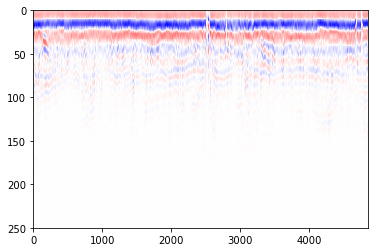

In [4]:
max_val = np.max(np.abs(data))

plt.figure()

plt.pcolormesh(
    data,
    vmin=-max_val, vmax=max_val,  # Make the colormap symmetric
    cmap='bwr')  # Choose colormap

plt.gca().invert_yaxis()
plt.show()

## GPRPy

Here a screenshot of the same as above, but using GPRPy.

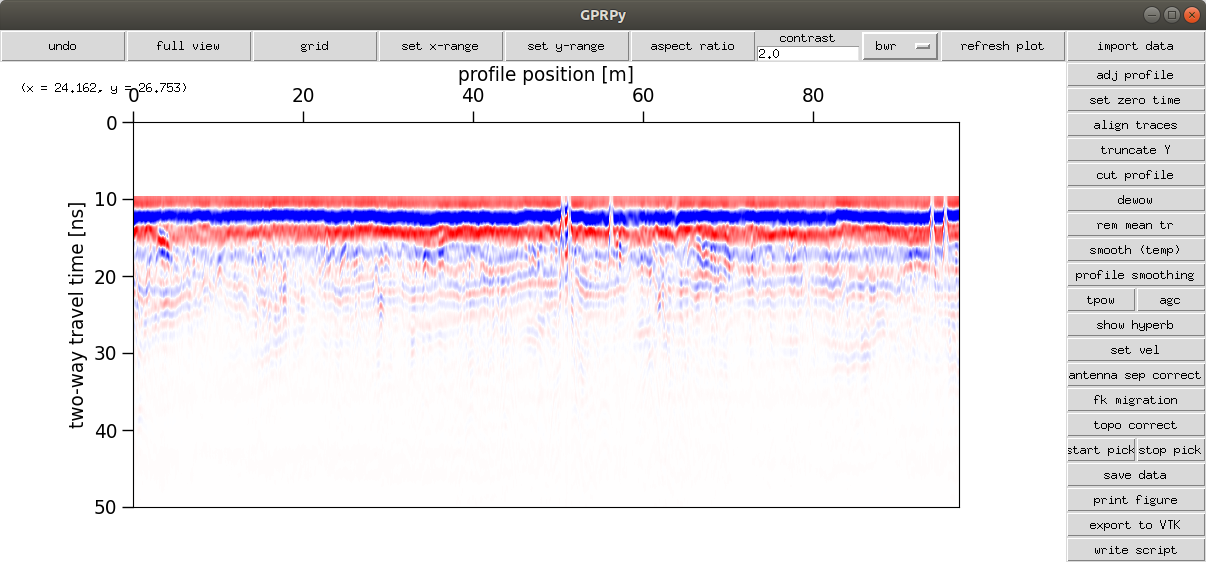